In [1]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import pandas as pd
from openpyxl import load_workbook
import re
import io
import os
import pdb

import sys
sys.path.append(os.path.abspath('../kev/'))

import eq_data
import eq_preproc
import eq_evaluator
import eq_postproc
import eq_writer


# basic input ------------------------------------------------
 
def cl_scripts_load(_sep, _subdir, _file):
    
    # if specific file selected it should be XLSX one
    if _file != "":
        
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        _file = _subdir + _file
        
        # open excel file
        with open(_file, "rb") as f:
            inmemory_file = io.BytesIO(f.read())
        wb = load_workbook(inmemory_file, read_only = True)
                
        r = re.compile(r'heats')
        heats_data = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], index_col = 0)
        
        r = re.compile(r'targets')
        targets = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0], header = None)
        
        r = re.compile(r'enthalpies')
        delta_H = pd.read_excel(_file, sheet_name = list(filter(r.search, wb.sheetnames))[0])
        
    # use a bunch of plain text files instead
    else:
          
        if _subdir != '':
            _subdir = '/' + _subdir
        _subdir = '../../input' + _subdir + '/'

        file_names = list(os.listdir(path = _subdir))

        r = re.compile(r'heats')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        heats_data = pd.read_csv(file, sep = _sep, decimal = ",", index_col = 0)
        
        r = re.compile(r'targets')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        targets = pd.read_csv(file, sep = _sep, header = None)
        
        r = re.compile(r'enthalpies')
        file = list(filter(r.search, file_names))[0]
        file = _subdir + str(file)
        delta_H = pd.read_csv(file, sep = _sep)
        
    return heats_data, targets, delta_H

In [2]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np
import re

# basic preprocessing ----------------------------------------
    
def cl_preproc(con_data, prod_names, idx, type_con, heats_data, targets, delta_H, _calor_setup_type):
    
    # checking if there are several series
    
    if 'series' not in con_data.columns:        
        con_data['series'] = ''
    
    if 'series' not in heats_data.index:
        heats_data.loc['series'] = '' # probably not needed
    
    if 'volumes' not in heats_data.index:
        heats_data.loc['volumes'] = 1        

    # series variables
    
    ser_info = con_data['series'].to_numpy()
    ser_unique = np.unique(ser_info)
    ser_num = np.shape(np.unique(ser_info))[0]
    
    ser_counts = con_data.groupby(['series']).size().tolist();
    
    # reading volumes from experimental data
    volumes = heats_data.loc['volumes'].to_numpy()
    
    # reading exp heats from experimental data
    heats = heats_data.loc['observation'].to_numpy() - heats_data.loc['dilution'].to_numpy()
        
    # transforming deviation to the matrix form
    devs = heats_data.loc['deviation'].to_numpy()
    devs = np.diag((1 / (np.array(devs) * np.array(devs))) * (np.sum(np.array(devs) * np.array(devs)) / len(devs)))
    
    # creating vector of known enthalpies
    dH_par = np.hstack((np.zeros(len(prod_names_con)), np.transpose(delta_H.drop('Reaction', axis = 1).to_numpy())[0]))
    
    # number of constant to find
    tar_names = set(targets.to_numpy()[0][1:])
    tar_num = [index for index, item in enumerate(prod_names) if item in tar_names]
    
    # number of enthalpy to find
    dH_names = np.hstack((prod_names_con, np.transpose(delta_H.drop('Value', axis = 1).to_numpy())[0]))
    un_el = set(prod_names) - set(dH_names)
    dH_ind_wtf = list([index for index, item in enumerate(prod_names) if item in un_el])
    un_el = set(prod_names) - (set(prod_names) - set(dH_names))
    dH_ind = list([index for index, item in enumerate(prod_names) if item in un_el])
    
    # creating array of diff total concentrations
    con_matrix_red = []
    for s in range(ser_num):
        for k in range(ser_counts[s] - 1):
            con_matrix_red.append(con_matrix[int(np.sum(ser_counts[:s])) + k + 1])
            
    if _calor_setup_type == 'DSC' or 'overfilled':
        _calor_setup_type_coeff = [[1] for i in range(len(con_matrix_red))]
    
    if _calor_setup_type == 'ampoule':
        _calor_setup_type_coeff = 1 / np.array(con_matrix_red)[:, idx] 
    
    return (ser_num, ser_counts, ser_info, volumes, heats, devs, tar_num, dH_ind, dH_ind_wtf, dH_par, 
            _calor_setup_type_coeff)

In [22]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

import numpy as np

def cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type):

    # finding the increment in equilibrium concentrations of products - needed for dH calculation
    vol_active = 0.988 # terrible solution. Gotta introduce new variable for operating volume 
                       # of calorimetric cell for overfilled mode
    dif_conc = []        
             
    for s in range(ser_num):    
        for k in range(ser_counts[s] - 1):
            
            if _calor_setup_type == 'overfilled':
                factor = 1 - (volumes[int(np.sum(ser_counts[:s])) + k - s] / vol_active)
            else:
                factor = 1
            
            dif_conc.append(c_res_out[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out[int(np.sum(ser_counts[:s])) +
                                                                                       k] * factor)
            
    dif_conc, devs, volumes = np.array(dif_conc).astype(np.float32), devs.astype(np.float32), volumes.astype(np.float32)
    
    # finding vector of experimental values
    s = [0] * len(heats)
    q_corr = deepcopy(heats)
    for i in range(len(heats)):
        for j in range(len(volumes[dH_ind])):
            
            if _calor_setup_type == 'overfilled':
                q_corr[i] -= vol_active * dif_conc[i, dH_ind[j]] * dH_par[j]
            else:
                q_corr[i] -= volumes[dH_ind[j]] * dif_conc[i, dH_ind[j]] * dH_par[j]
                s[i] += volumes[dH_ind[j]] * dif_conc[i, dH_ind[j]] * dH_par[j]
    if _calor_setup_type == 'overfilled':
        A = (vol_active * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff)
    else:
        A = (volumes[dH_ind_wtf] * dif_conc[:, dH_ind_wtf]) * np.array(_calor_setup_type_coeff) 
    
    AT = np.transpose(A)
    LTP = np.linalg.inv(np.dot(np.dot(AT, devs), A))
    RTP = np.dot(np.dot(AT, devs), q_corr)
    dH_res = np.dot(LTP, RTP)
    dH_res_tmp = dH_par

    for i in range(len(dH_ind_wtf)):
        dH_res_tmp = np.insert(dH_res_tmp, dH_ind_wtf[i], dH_res[i])

    dH_res_out = dH_res_tmp

    F_min, heats_calc = 0, []
    
    for i in range(len(heats)): 
        
        if _calor_setup_type == 'overfilled':
            F_min += (vol_active * np.sum(dH_res_out * dif_conc[i] * np.array(_calor_setup_type_coeff[i])) - heats[i]) ** 2
            heats_calc.append(np.sum(dH_res_out * dif_conc[i] * vol_active * _calor_setup_type_coeff[i]))
        
        else:
            F_min += (np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i])) - heats[i]) ** 2
            heats_calc.append(np.sum(dH_res_out * dif_conc[i] * volumes[i] * np.array(_calor_setup_type_coeff[i])))
    print('\neq con')
    print(np.array(c_res_out))
    print('\ndif con')
    print(dif_conc)
    print('\nvol')
    print(volumes)
    print('\ndH par')
    print(dH_par)
    print('\nsum of terms')
    print(np.array(s))
    
    #print(sum(heats))
    #print(dH_res_out)
    #print(np.sum(dif_conc[i]))
    #print(np.sum(volumes[i]))
    #print(np.sum(np.array(_calor_setup_type_coeff[i])))
    
    # calculating st. dev. of dH_res / checking the quality of linear regression
    # consider making it in separate function
    
    disp = (F_min / (len(heats) - len(dH_ind_wtf)) * (np.diag(LTP))) ** 0.5  
    
    return F_min, dH_res_out, disp

In [4]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------

from copy import deepcopy
import eq_evaluator
# import also script cl_enthalpies when needed

# main Hooke-Jeeves procedure --------------------------------
def cl_hooke_jeeves(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type):

    basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type)
    print(new_min)

    for i in range(max_iter):
        print('\niteration', i, lg_k[tar_num])
        if F_min <= new_min:
        
            if step_init < HJ_eps:
                print("p1 " + str(step_init) + " " + str(HJ_eps))
                break
            
            else: 
                 
                step_init /= 2
            
                basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num,
                                  st_coeff_matrix, type_con, con_matrix, ign_indices, ser_counts, ser_info, devs,
                                  volumes, heats, dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)
                print('\nF min more ', new_min, F_min, lg_k[tar_num])
                print(str(step_init))
        else:
            F_min = deepcopy(new_min)
            print('\nF min less', new_min, F_min, lg_k[tar_num])
            print(str(step_init))
            basis_point_n = deepcopy(lg_k)
            lg_k[tar_num] = basis_point[tar_num] + 2 * (lg_k[tar_num] - basis_point[tar_num])

            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                    con_matrix, ign_indices)

            new_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats
                                          , dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)
            print('\nF min less after', new_min, F_min, lg_k[tar_num])
        
            if F_min <= new_min:
                lg_k = deepcopy(basis_point_n)
                print('\nconstant less after', basis_point[tar_num], lg_k[tar_num]) 
            else:
                F_min = new_min

            basis_point, lg_k, new_min, c_res_out, disp = cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num,
                                  st_coeff_matrix, type_con, con_matrix, ign_indices, ser_counts, ser_info, devs,
                                  volumes, heats, dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)
        
            if F_min <= new_min:
            
                print('\nF min p2', new_min, F_min, lg_k[tar_num])
                if step_init < HJ_eps:
                    print("p2")
                    break
            
                else: 
                
                    step_init /= 2
        
            else:

                F_min = deepcopy(new_min)
            
                print('\nF min p3.1', new_min, F_min, lg_k[tar_num])
            
                basis_point_n = deepcopy(lg_k)
                lg_k[tar_num] = basis_point[tar_num] + 2 * (lg_k[tar_num] - basis_point[tar_num])
            
                c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                        con_matrix, ign_indices)
    
                new_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats
                                              , dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)
        
                if F_min <= new_min:
                    lg_k = deepcopy(basis_point_n)
            
                print('\nF min p3.2', new_min, F_min, lg_k[tar_num])
    
    return F_min, lg_k, dH_res_out, c_res_out, disp

# exploratory move function used in main function ------------------------
def cl_exploratory(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type):

    basis_point = deepcopy(lg_k)
    
    c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k, 
                                                con_matrix, ign_indices)

    new_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats
                                          , dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)

    #if F_min > new_min:
    F_min = new_min
    
    for j in range(len(tar_num)): 
        #pdb.set_trace()
        print('input', lg_k[tar_num[j]], F_min)
        
        lg_k[tar_num[j]] = lg_k[tar_num[j]] + step_init
        
        c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices)
        #print('\na1 ', new_min, F_min)
        new_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                   _calor_setup_type_coeff, _calor_setup_type)
        print('right', lg_k[tar_num[j]], new_min, F_min)
        #print('\na2 ', new_min, F_min)
        if F_min <= new_min:
            
            lg_k[tar_num[j]] = lg_k[tar_num[j]] - 2 * step_init
            
            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k, 
                                                        con_matrix, ign_indices)
        
            new_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats
                                                  , dH_ind, dH_par, dH_ind_wtf, _calor_setup_type_coeff, _calor_setup_type)
            print('left', lg_k[tar_num[j]], new_min, F_min)
            #print('\na3 ', new_min, F_min)
            if F_min <= new_min:
                
                lg_k[tar_num[j]] = lg_k[tar_num[j]] + step_init
                new_min = deepcopy(F_min)
                #print('\na4 ', new_min, F_min)
            #else:
                
                #new_min = deepcopy(F_min)
                
        #else:
            
            #new_min = deepcopy(F_min)
    print('return', basis_point[tar_num[j]], lg_k[tar_num[j]])
    #print('\na5 ', new_min, F_min)
    return basis_point, lg_k, new_min, c_res_out, disp

In [5]:
# ########################################################## #
#                                                            #
# Name: KEV:Constant Evaluator                               #
# Author: GGamov                                             #
# Date: 2019                                                 #
#                                                            #
# ########################################################## #

# import libraries -------------------------------------------
import numpy as np
import eq_evaluator
# import also script cl_enthalpies when needed

def cl_constants_errs(lg_k, heats, tar_num, HJ_eps, max_iter, eps, st_coeff_matrix, type_con, con_matrix,
                      ign_indices, ser_num, ser_counts, devs, volumes, dH_ind, dH_par, dH_ind_wtf, 
                      _calor_setup_type_coeff, _calor_setup_type):
    
    # creating constants vectors ---------------------------------
    lg_k_1, lg_k_2 = np.array(lg_k), np.array(lg_k)
    heats_one, heats_two = [0] * len(heats), [0] * len(heats)
    jc_mtrx = [[0] * len(heats) for i in range(len(tar_num))]

    for i in range(len(tar_num)):
        # calculating the heats for Jacobi matrix computing
        lg_k_1[tar_num[i]] += HJ_eps
        lg_k_2[tar_num[i]] -= HJ_eps
    
        # if lg_k is overestimated
        c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k_1,
                                                        con_matrix, ign_indices)
    
        new_min, dH_res_out_dist, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                                       _calor_setup_type_coeff, _calor_setup_type)
    
        dif_conc = [] 
        for s in range(ser_num):    
            for k in range(ser_counts[s] - 1):
                dif_conc.append(c_res_out_dist[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out_dist[int(np.sum(ser_counts[:s])) + k])
    
        for o in range(len(heats)):
            heats_one[o] = np.sum(dif_conc[o] * dH_res_out_dist) * volumes[o]
    
        # if lg_k is underestimated    
        c_res_out_dist, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k_2,
                                                        con_matrix, ign_indices)
    
        new_min, dH_res_out_dist, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                                       _calor_setup_type_coeff, _calor_setup_type)
    
        dif_conc = [] 
        for s in range(ser_num):    
            for k in range(ser_counts[s] - 1):
                dif_conc.append(c_res_out_dist[int(np.sum(ser_counts[:s])) + k + 1] - c_res_out_dist[int(np.sum(ser_counts[:s])) + k])    
   
        for o in range(len(heats)):
            heats_two[o] = np.sum(dif_conc[o] * dH_res_out_dist) * volumes[o]
    
    # calculating the Jacobi matrix    
    jc_mtrx[i] = (np.array(heats_one) - np.array(heats_two)) / (2 * HJ_eps)

    jc_mtrx, devs = np.array(jc_mtrx).astype(np.float32), devs.astype(np.float32)

    cov_matrix = (F_min / (len(heats) - len(tar_num))) * np.linalg.inv(np.dot(np.dot(jc_mtrx, devs), np.transpose(jc_mtrx)))

    errs_values = np.diag(cov_matrix) ** 0.5
    return errs_values

In [6]:
# input for xlsx file
_subdir = "calorimetry"
_sep = ";"
_file = "test_5.xlsx"
_calor_setup_type = 'DSC' # use 'DSC' for test_1 and test_2; use 'ampoule' for test_3; use 'overfilled' for test_4

max_iter, eps, HJ_eps, step_init = 100, 0.0000001, 0.0001, 0.5

# load data

st_coeff_data, lg_k_data, con_data, type_con, component_name_for_yields = eq_data.eq_scripts_load(_sep, _subdir, _file)
heats_data, targets, delta_H = cl_scripts_load(_sep, _subdir, _file)

# preproc

st_coeff_matrix, prod_names, lg_k, prod_names_con, con_matrix, ign_indices, idx, type_con = eq_preproc.eq_preproc(
    st_coeff_data, con_data, type_con, lg_k_data, component_name_for_yields)

(ser_num, ser_counts, ser_info, volumes, heats, devs, 
 tar_num, dH_ind, dH_ind_wtf, dH_par, _calor_setup_type_coeff) = cl_preproc(
    con_data, prod_names, idx, type_con, heats_data, targets, delta_H, _calor_setup_type)
#----
#lg_k[tar_num] = 10 # it is just for quick variation of initial approximation of the constant to be optimized. Delete in the end
#----

# calculation of eq concentration (starting point)
c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
            con_matrix, ign_indices)

# calculation of F_min and unknown enthalpies (starting point)
F_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff, _calor_setup_type)

# F_min assignment for further calculations
new_min = F_min
print(F_min)
print(dH_res_out)
print(disp)
# constant refinment
if len(tar_num) > 0:
    F_min, lg_k, dH_res_out, c_res_out, disp = cl_hooke_jeeves(F_min, tar_num, lg_k, step_init, max_iter, eps, ser_num, st_coeff_matrix, type_con,
        con_matrix, ign_indices, ser_counts, ser_info, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                _calor_setup_type_coeff, _calor_setup_type)


F_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff, _calor_setup_type)

print(lg_k)
print(dH_res_out)
# error estimation
#if len(tar_num) > 0:
    #errs_values = cl_constants_errs(lg_k, heats, tar_num, HJ_eps, max_iter, eps, st_coeff_matrix, type_con, con_matrix,
                                    #ign_indices, ser_num, ser_counts, devs, volumes, dH_ind, dH_par, dH_ind_wtf, 
                                    #_calor_setup_type_coeff, _calor_setup_type)

0.19506000000000004
[ 0.  0. 30. 10.]
0.0001535365
15.49994
1
0.007701748782368302
[ 0.  0. 30. 10.]
[]
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001535365
15.49994
1
input [4.] 0.007701748782368302
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001553472
15.49994
1
right [4.5] 0.011867635459776118 0.007701748782368302
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015019691
15.49994
1
left [3.5] 0.0030269449461823687 0.007701748782368302
input [6.] 0.007701748782368302
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015129214
15.49994
1
right [6.5] 0.0019628604950964 0.007701748782368302
return [6.] [6.5]
0.0019628604950964

iteration 0 [[3.5]
 [6.5]]

F min less 0.0019628604950964 0.0019628604950964 [[3.5]
 [6.5]]
0.5
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015275083
15.49994
1

F min less after 0.0001141714066462109 0.0019628604950964 [[3.]
 [7.]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015275083
15.49994
1
input [3.] 0.0001141714066462109
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015279422
15.49

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015112886
15.49994
1
right [2.96875] 5.551359163016298e-05 5.5005463650648886e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015113312
15.49994
1
left [2.953125] 5.4934974686190055e-05 5.5005463650648886e-05
input [6.6015625] 5.5005463650648886e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015116896
15.49994
1
right [6.609375] 5.5401393548183185e-05 5.5005463650648886e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.000151097
15.49994
1
left [6.59375] 5.4528007616222476e-05 5.5005463650648886e-05
return [6.6015625] [6.59375]

F min p3.1 5.4528007616222476e-05 5.4528007616222476e-05 [[2.953125]
 [6.59375 ]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015106292
15.49994
1

F min p3.2 5.423035381519215e-05 5.4528007616222476e-05 [[2.9453125]
 [6.5859375]]

iteration 10 [[2.9453125]
 [6.5859375]]

F min less 5.423035381519215e-05 5.423035381519215e-05 [[2.9453125]
 [6.5859375]]
0.0078125
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015099451
15.49994
1

F min

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015070803
15.49994
1
left [6.50976562] 5.067217676949583e-05 5.0766824085241956e-05
return [6.51171875] [6.50976562]

F min more  5.067217676949583e-05 5.0766824085241956e-05 [[2.92382812]
 [6.50976562]]
0.001953125

iteration 18 [[2.92382812]
 [6.50976562]]

F min less 5.067217676949583e-05 5.067217676949583e-05 [[2.92382812]
 [6.50976562]]
0.001953125
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001506992
15.49994
1

F min less after 5.058947361624042e-05 5.067217676949583e-05 [[2.921875 ]
 [6.5078125]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001506992
15.49994
1
input [2.921875] 5.058947361624042e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015069862
15.49994
1
right [2.92382812] 5.059279809312027e-05 5.058947361624042e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015069977
15.49994
1
left [2.91992188] 5.061323385565297e-05 5.058947361624042e-05
input [6.5078125] 5.058947361624042e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015070863
15.4999

 [6.4609375]]

F min less 4.867361074347079e-05 4.867361074347079e-05 [[2.90625  ]
 [6.4609375]]
0.001953125
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001504569
15.49994
1

F min less after 4.855321656960267e-05 4.867361074347079e-05 [[2.90234375]
 [6.45703125]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001504569
15.49994
1
input [2.90234375] 4.855321656960267e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015045628
15.49994
1
right [2.90429688] 4.852553638900162e-05 4.855321656960267e-05
input [6.45703125] 4.855321656960267e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015046592
15.49994
1
right [6.45898438] 4.860724111418008e-05 4.855321656960267e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015044662
15.49994
1
left [6.45507812] 4.844723714329423e-05 4.855321656960267e-05
return [6.45703125] [6.45507812]

F min p3.1 4.844723714329423e-05 4.844723714329423e-05 [[2.90429688]
 [6.45507812]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015043633
15.49994
1

F min p3.2 4.839038825232134e-05 4.

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015024624
15.49994
1

F min p3.2 4.6949598892877796e-05 4.701981033653872e-05 [[2.890625 ]
 [6.4140625]]

iteration 34 [[2.890625 ]
 [6.4140625]]

F min less 4.6949598892877796e-05 4.6949598892877796e-05 [[2.890625 ]
 [6.4140625]]
0.001953125
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015022785
15.49994
1

F min less after 4.684747643646162e-05 4.6949598892877796e-05 [[2.88671875]
 [6.41015625]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015022785
15.49994
1
input [2.88671875] 4.684747643646162e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015022722
15.49994
1
right [2.88867188] 4.681868557371683e-05 4.684747643646162e-05
input [6.41015625] 4.684747643646162e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015023706
15.49994
1
right [6.41210938] 4.689216257430666e-05 4.684747643646162e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015021735
15.49994
1
left [6.40820312] 4.674853534369252e-05 4.684747643646162e-05
return [6.41015625] [6.40820312]

F mi

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015001083
15.49994
1

F min less after 4.561273045371087e-05 4.5564412013780074e-05 [[2.8828125]
 [6.3671875]]

constant less after [[2.875]
 [6.375]] [[2.87890625]
 [6.37109375]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001500321
15.49994
1
input [2.87890625] 4.5564412013780074e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015003145
15.49994
1
right [2.88085938] 4.560419986037004e-05 4.5564412013780074e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015003275
15.49994
1
left [2.87695312] 4.555252066799531e-05 4.5564412013780074e-05
input [6.37109375] 4.5564412013780074e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015004272
15.49994
1
right [6.37304688] 4.561400120885679e-05 4.5564412013780074e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015002275
15.49994
1
left [6.36914062] 4.5494252018553055e-05 4.5564412013780074e-05
return [6.37109375] [6.36914062]

F min p3.1 4.5494252018553055e-05 4.5494252018553055e-05 [[2.87695312]
 [6.36914062]]
0.195

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014979509
15.49994
1
right [2.86523438] 4.427931599338043e-05 4.425120147294276e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014979643
15.49994
1
left [2.86132812] 4.4251125629107174e-05 4.425120147294276e-05
input [6.32421875] 4.425120147294276e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014980655
15.49994
1
right [6.32617188] 4.4306366056662107e-05 4.425120147294276e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014978627
15.49994
1
left [6.32226562] 4.419903609288307e-05 4.425120147294276e-05
return [6.32421875] [6.32226562]

F min p3.1 4.419903609288307e-05 4.419903609288307e-05 [[2.86132812]
 [6.32226562]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001497768
15.49994
1

F min p3.2 4.4160539535176096e-05 4.419903609288307e-05 [[2.859375 ]
 [6.3203125]]

iteration 50 [[2.859375 ]
 [6.3203125]]

F min less 4.4160539535176096e-05 4.4160539535176096e-05 [[2.859375 ]
 [6.3203125]]
0.001953125
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014975786
1

0.19506000000000004
[ 0.  0. 30. 10.]
0.0001495745
15.49994
1
right [2.85351562] 4.3339667526157396e-05 4.329009907267152e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014957589
15.49994
1
left [2.84960938] 4.326890168064788e-05 4.329009907267152e-05
input [6.28125] 4.329009907267152e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014958615
15.49994
1
right [6.28320312] 4.330787682070089e-05 4.329009907267152e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001495656
15.49994
1
left [6.27929688] 4.323295802312717e-05 4.329009907267152e-05
return [6.28125] [6.27929688]

F min p3.1 4.323295802312717e-05 4.323295802312717e-05 [[2.84960938]
 [6.27929688]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014955601
15.49994
1

F min p3.2 4.3190019734652055e-05 4.323295802312717e-05 [[2.84765625]
 [6.27734375]]

iteration 57 [[2.84765625]
 [6.27734375]]

F min less 4.3190019734652055e-05 4.3190019734652055e-05 [[2.84765625]
 [6.27734375]]
0.001953125
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014953685
15.

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014936463
15.49994
1
right [6.24023438] 4.2570309157305334e-05 4.257732387905054e-05
return [6.23828125] [6.24023438]

F min p3.1 4.2570309157305334e-05 4.2570309157305334e-05 [[2.83398438]
 [6.24023438]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014937429
15.49994
1

F min p3.2 4.257779230706977e-05 4.2570309157305334e-05 [[2.83398438]
 [6.24023438]]

iteration 64 [[2.83398438]
 [6.24023438]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014936463
15.49994
1
input [2.83398438] 4.2570309157305334e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014936426
15.49994
1
right [2.83496094] 4.255294802257262e-05 4.2570309157305334e-05
input [6.24023438] 4.2570309157305334e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014936946
15.49994
1
right [6.24121094] 4.257223164320177e-05 4.2570309157305334e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014935908
15.49994
1
left [6.23925781] 4.2534379293059e-05 4.2570309157305334e-05
return [6.24023438] [6.23925781]

F 

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014925086
15.49994
1

F min less after 4.224974215279274e-05 4.226944960044174e-05 [[2.83203125]
 [6.21875   ]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014925086
15.49994
1
input [2.83203125] 4.224974215279274e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001492505
15.49994
1
right [2.83300781] 4.226372796832982e-05 4.224974215279274e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014925122
15.49994
1
left [2.83105469] 4.22428814134687e-05 4.224974215279274e-05
input [6.21875] 4.224974215279274e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014925643
15.49994
1
right [6.21972656] 4.225443337705973e-05 4.224974215279274e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.000149246
15.49994
1
left [6.21777344] 4.2232034399951784e-05 4.224974215279274e-05
return [6.21875] [6.21777344]

F min p3.1 4.2232034399951784e-05 4.2232034399951784e-05 [[2.83105469]
 [6.21777344]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014924114
15.49994
1

F min p3.2 4.22180623784

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014913952
15.49994
1
input [2.82226562] 4.202238380521245e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014913914
15.49994
1
right [2.82324219] 4.2010253203165465e-05 4.202238380521245e-05
input [6.19726562] 4.202238380521245e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014914438
15.49994
1
right [6.19824219] 4.202244211864971e-05 4.202238380521245e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001491339
15.49994
1
left [6.19628906] 4.199876768816641e-05 4.202238380521245e-05
return [6.19726562] [6.19628906]

F min p3.1 4.199876768816641e-05 4.199876768816641e-05 [[2.82324219]
 [6.19628906]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014912829
15.49994
1

F min p3.2 4.198702974639037e-05 4.199876768816641e-05 [[2.82421875]
 [6.1953125 ]]

iteration 79 [[2.82421875]
 [6.1953125 ]]

F min less 4.198702974639037e-05 4.198702974639037e-05 [[2.82421875]
 [6.1953125 ]]
0.0009765625
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014911706
15.49994
1

F min l

0.19506000000000004
[ 0.  0. 30. 10.]
0.0001490259
15.49994
1
right [2.81738281] 4.1833065104879066e-05 4.1843568030079474e-05
input [6.17578125] 4.1843568030079474e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014903114
15.49994
1
right [6.17675781] 4.184191352021788e-05 4.1843568030079474e-05
return [6.17578125] [6.17675781]

F min p3.1 4.184191352021788e-05 4.184191352021788e-05 [[2.81738281]
 [6.17675781]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014903603
15.49994
1

F min p3.2 4.1844066145638975e-05 4.184191352021788e-05 [[2.81738281]
 [6.17675781]]

iteration 86 [[2.81738281]
 [6.17675781]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014903114
15.49994
1
input [2.81738281] 4.184191352021788e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014903095
15.49994
1
right [2.81787109] 4.183833604761583e-05 4.184191352021788e-05
input [6.17675781] 4.184191352021788e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001490336
15.49994
1
right [6.17724609] 4.1842514888324106e-05 4.184191352021788e-

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014897437
15.49994
1
input [2.81445312] 4.1775648260335934e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014897418
15.49994
1
right [2.81494141] 4.1772346383448846e-05 4.1775648260335934e-05
input [6.16601562] 4.1775648260335934e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014897683
15.49994
1
right [6.16650391] 4.177571104106148e-05 4.1775648260335934e-05
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014897155
15.49994
1
left [6.16552734] 4.176914503688695e-05 4.1775648260335934e-05
return [6.16601562] [6.16552734]

F min p3.1 4.176914503688695e-05 4.176914503688695e-05 [[2.81494141]
 [6.16552734]]
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014896874
15.49994
1

F min p3.2 4.17656051684258e-05 4.176914503688695e-05 [[2.81542969]
 [6.16503906]]

iteration 94 [[2.81542969]
 [6.16503906]]

F min less 4.17656051684258e-05 4.17656051684258e-05 [[2.81542969]
 [6.16503906]]
0.00048828125
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014896308
15.49994
1

F m

In [7]:
print(np.array(c_res_out))
#print(c_res_out[int(np.sum(ser_counts[:0])) + 1])

[[1.00000000e-03 3.24423138e-17 2.10674427e-17 4.64902435e-17]
 [8.32410165e-04 6.56757936e-05 3.55011731e-05 6.52123843e-05]
 [7.07572295e-04 1.52611813e-04 7.01227552e-05 1.09491345e-04]
 [6.14926865e-04 2.56291907e-04 1.02343051e-04 1.38877480e-04]
 [5.44930007e-04 3.72177202e-04 1.31701430e-04 1.58373025e-04]
 [4.90669837e-04 4.96770022e-04 1.58286815e-04 1.71389457e-04]
 [4.47502395e-04 6.27609145e-04 1.82383114e-04 1.80106750e-04]
 [4.12345757e-04 7.62997617e-04 2.04307689e-04 1.85907214e-04]
 [3.83126958e-04 9.01755496e-04 2.24352808e-04 1.89681170e-04]
 [3.58419636e-04 1.04304638e-03 2.42770222e-04 1.92015908e-04]
 [3.37217511e-04 1.18626400e-03 2.59771480e-04 1.93308783e-04]
 [3.18793184e-04 1.33095903e-03 2.75533059e-04 1.93835242e-04]
 [3.02608865e-04 1.47679152e-03 2.90202292e-04 1.93790501e-04]
 [2.88258736e-04 1.62349937e-03 3.03902731e-04 1.93315679e-04]
 [2.75430877e-04 1.77087707e-03 3.16738634e-04 1.92514597e-04]
 [2.63881563e-04 1.91876100e-03 3.28798579e-04 1.914648

In [8]:
#print('\nStoich coeff data')
#print(st_coeff_data)

#print('\nlg K')
#print(lg_k_data)

#print('\nconcentrations')
#print(con_data)

#print('\ntype con')
#print(type_con)

#print('\nexperimental data')
#print(heats_data)

print('\n_calor_setup_type_coeff')
print(_calor_setup_type_coeff)

print('\ntargets')
print(targets)

#print('\ndelta_H')
#print(delta_H)


_calor_setup_type_coeff
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]

targets
            0   1    2
0  constants   HL  H2L


In [9]:
print('\nSeries')
print(ser_num)
print(ser_counts)
print(ser_info)

print('\nSt coeff matr')
print(st_coeff_matrix)

print('\nprod names')
print(prod_names)
print(prod_names_con)

print('\nconst')
print(lg_k)

print('\nconcentrations')
print(con_matrix)

print(ign_indices)

print('\ntype con')
print(type_con)

print('\nvolumes')
print(volumes)

print('\nheats')
print(heats)

print('\ndeviations')
print(devs)

print('\nwhat to find and what is known')
print(tar_num)
print(dH_ind)
print(dH_ind_wtf)

print('\nenthalpies')
print(dH_par)


Series
1
[21]
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']

St coeff matr
[[1 0]
 [0 1]
 [1 1]
 [2 1]]

prod names
['H', 'L', 'HL', 'H2L']
['H', 'L']

const
[[0.     ]
 [0.     ]
 [2.8125 ]
 [6.15625]]

concentrations
[[1.00000000e-03 1.00000000e-16]
 [9.98336106e-04 1.66389351e-04]
 [9.96677741e-04 3.32225914e-04]
 [9.95024876e-04 4.97512438e-04]
 [9.93377483e-04 6.62251656e-04]
 [9.91735537e-04 8.26446281e-04]
 [9.90099010e-04 9.90099010e-04]
 [9.88467875e-04 1.15321252e-03]
 [9.86842105e-04 1.31578947e-03]
 [9.85221675e-04 1.47783251e-03]
 [9.83606557e-04 1.63934426e-03]
 [9.81996727e-04 1.80032733e-03]
 [9.80392157e-04 1.96078431e-03]
 [9.78792822e-04 2.12071778e-03]
 [9.77198697e-04 2.28013029e-03]
 [9.75609756e-04 2.43902439e-03]
 [9.74025974e-04 2.59740260e-03]
 [9.72447326e-04 2.75526742e-03]
 [9.70873786e-04 2.91262136e-03]
 [9.69305331e-04 3.06946688e-03]
 [9.67741935e-04 3.22580645e-03]]
[]

type con
0    tot
1    tot
Name: 0, dtype: object

volumes
[15.

In [10]:
print('\nEq conc')
print(np.array(c_res_out))
print(np.shape(c_res_out))


Eq conc
[[1.00000000e-03 3.24423138e-17 2.10674427e-17 4.64902435e-17]
 [8.32410165e-04 6.56757936e-05 3.55011731e-05 6.52123843e-05]
 [7.07572295e-04 1.52611813e-04 7.01227552e-05 1.09491345e-04]
 [6.14926865e-04 2.56291907e-04 1.02343051e-04 1.38877480e-04]
 [5.44930007e-04 3.72177202e-04 1.31701430e-04 1.58373025e-04]
 [4.90669837e-04 4.96770022e-04 1.58286815e-04 1.71389457e-04]
 [4.47502395e-04 6.27609145e-04 1.82383114e-04 1.80106750e-04]
 [4.12345757e-04 7.62997617e-04 2.04307689e-04 1.85907214e-04]
 [3.83126958e-04 9.01755496e-04 2.24352808e-04 1.89681170e-04]
 [3.58419636e-04 1.04304638e-03 2.42770222e-04 1.92015908e-04]
 [3.37217511e-04 1.18626400e-03 2.59771480e-04 1.93308783e-04]
 [3.18793184e-04 1.33095903e-03 2.75533059e-04 1.93835242e-04]
 [3.02608865e-04 1.47679152e-03 2.90202292e-04 1.93790501e-04]
 [2.88258736e-04 1.62349937e-03 3.03902731e-04 1.93315679e-04]
 [2.75430877e-04 1.77087707e-03 3.16738634e-04 1.92514597e-04]
 [2.63881563e-04 1.91876100e-03 3.28798579e-04

In [11]:
print('\nlg K')
print(lg_k)

print('\nF_min')
print(F_min)

print('\nFinal enthalpies')
print(dH_res_out)

print('\ncalculated error of enthalpy')
print(disp)

#if len(tar_num) > 0:
    #print('\ncalculated error of constant')
    #print(errs_values)


lg K
[[0.     ]
 [0.     ]
 [2.8125 ]
 [6.15625]]

F_min
4.1725487406212766e-05

Final enthalpies
[ 0.  0. 30. 10.]

calculated error of enthalpy
[]


In [12]:
#import matplotlib.pyplot

#s = 4.5

#xxx = []
#FFF = []
#while s < 5.5:
    #lg_k[tar_num] = s
    
    #c_res_out = eq_calc(max_iter, eps, ser_num, st_coeff_matrix, type_con, lg_k,
        #con_matrix, ign_indices, ser_counts, ser_info)
        
    #F_min, dH_res_out = enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               #_calor_setup_type_coeff)
    
    #xxx.append(s)
    #FFF.append(F_min)
    #s += 0.02


#matplotlib.pyplot.plot(xxx, FFF, 'ro-')

#import sys
#import os
##sys.path.append('../kev_calorim')
#print(os.path.abspath('../kev/'))
#print(os.getcwd())

#lg_k is array

In [13]:
import matplotlib.pyplot as plt
from copy import copy, deepcopy

def risovalka(max_iter, eps, st_coeff_matrix, type_con, lg_k, con_matrix, ign_indices, ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff, _calor_setup_type):

    s = [[0] * 42 for i in range(42)]
    const_x = [0] * 42
    const_y = [0] * 42
    s = np.array(s)

    i, a = 3, 0

    for counter_x in range(len(s)):
        j = 5
        const_x[counter_x] = round(i, 2)
        for counter_y in range(len(s)):
            lg_k[2], lg_k[3] = np.array(i), np.array(j)
            const_y[counter_y] = round(j, 2)
            c_res_out, g_res_out = eq_evaluator.eq_calc(max_iter, eps, st_coeff_matrix, type_con, lg_k,
                                                            con_matrix, ign_indices)
        
            F_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                                       _calor_setup_type_coeff, _calor_setup_type)
            
            s[counter_x, counter_y] = float(F_min * 100000000)
        
            j += 0.05
    
        i += 0.05

    s = pd.DataFrame(data = s, index = const_y, columns = const_x)

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(s, cmap = 'RdYlGn_r')
    ax.set_xticks(np.arange(len(const_x)))
    ax.set_yticks(np.arange(len(const_y)))

    ax.set_xlabel('lg K1')
    ax.set_ylabel('lg K2')

    ax.set_xticklabels(const_x)
    ax.set_yticklabels(const_y)

    plt.show()
    return s

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014482603
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001449058
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014499306
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014508833
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001451921
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014530479
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014542678
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014555841
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014569997
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001458516
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014601348
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014618551
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014636763
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014655959
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014676104
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014697148
15.499

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014690874
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014704083
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014718222
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014733292
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014749293
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014766208
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014784011
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014802665
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014822112
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014842303
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014863163
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001488461
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001490656
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014928922
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.000149516
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014974493
15.4999

0.19506000000000004
[ 0.  0. 30. 10.]
0.00014931739
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014948574
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014966057
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014984122
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015002699
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015021712
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015041078
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015060714
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015080521
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015100435
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015120348
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015140188
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015159875
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015179339
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015198509
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001521733
15.4

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015098143
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015113426
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015129092
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015145082
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001516132
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015177738
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015194259
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015210806
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015227312
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015243705
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015259923
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015275899
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015291604
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014947006
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00014948171
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001494947
15.49

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015290442
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015303711
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015090826
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015091359
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015091957
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015092624
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001509337
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015094205
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015095135
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015096174
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015097333
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015098623
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015100064
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015101662
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001510344
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015105415
15.49

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015221529
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015222408
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015223384
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015224473
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015225683
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015227031
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015228524
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015230183
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015232021
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015234055
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015236302
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015238767
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015241501
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015244495
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015247775
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015251363
15.

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015325114
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015325901
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015326777
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015327753
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015328838
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015330041
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015331374
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015332851
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015334485
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015336285
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015338269
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015340452
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015342845
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015345463
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015348324
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015351434
15.

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015406992
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015407754
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015408598
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015409532
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001541057
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001541172
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015412987
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015414378
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015415922
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015417613
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015419465
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001542149
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015423697
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015426097
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015428699
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015423585
15.499

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015472727
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015473785
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001547495
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480553
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480563
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480573
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480588
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480602
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480618
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480636
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480655
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001548068
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480703
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480732
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480764
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015480802
15.49

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523053
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523063
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523072
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523084
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523095
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523109
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523125
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001552314
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523158
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001552318
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523205
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523232
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001552326
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523295
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523333
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015523373
15.499

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554277
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554288
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554299
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554311
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554325
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001555434
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554359
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554376
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554398
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554423
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554452
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554481
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554517
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554555
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554599
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015554647
15.4

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015576994
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577007
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577023
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577042
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577063
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577086
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577112
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001557713
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577168
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577202
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577242
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577285
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015577336
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015582942
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001558294
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015582942
15.49

0.19506000000000004
[ 0.  0. 30. 10.]
0.00015593319
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015593329
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015593338
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001559335
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015593367
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015593383
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.000155934
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001559759
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015597588
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015597588
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001559759
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015597588
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001559759
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001559759
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.00015597588
15.49994
1
0.19506000000000004
[ 0.  0. 30. 10.]
0.0001559759
15.49994
1


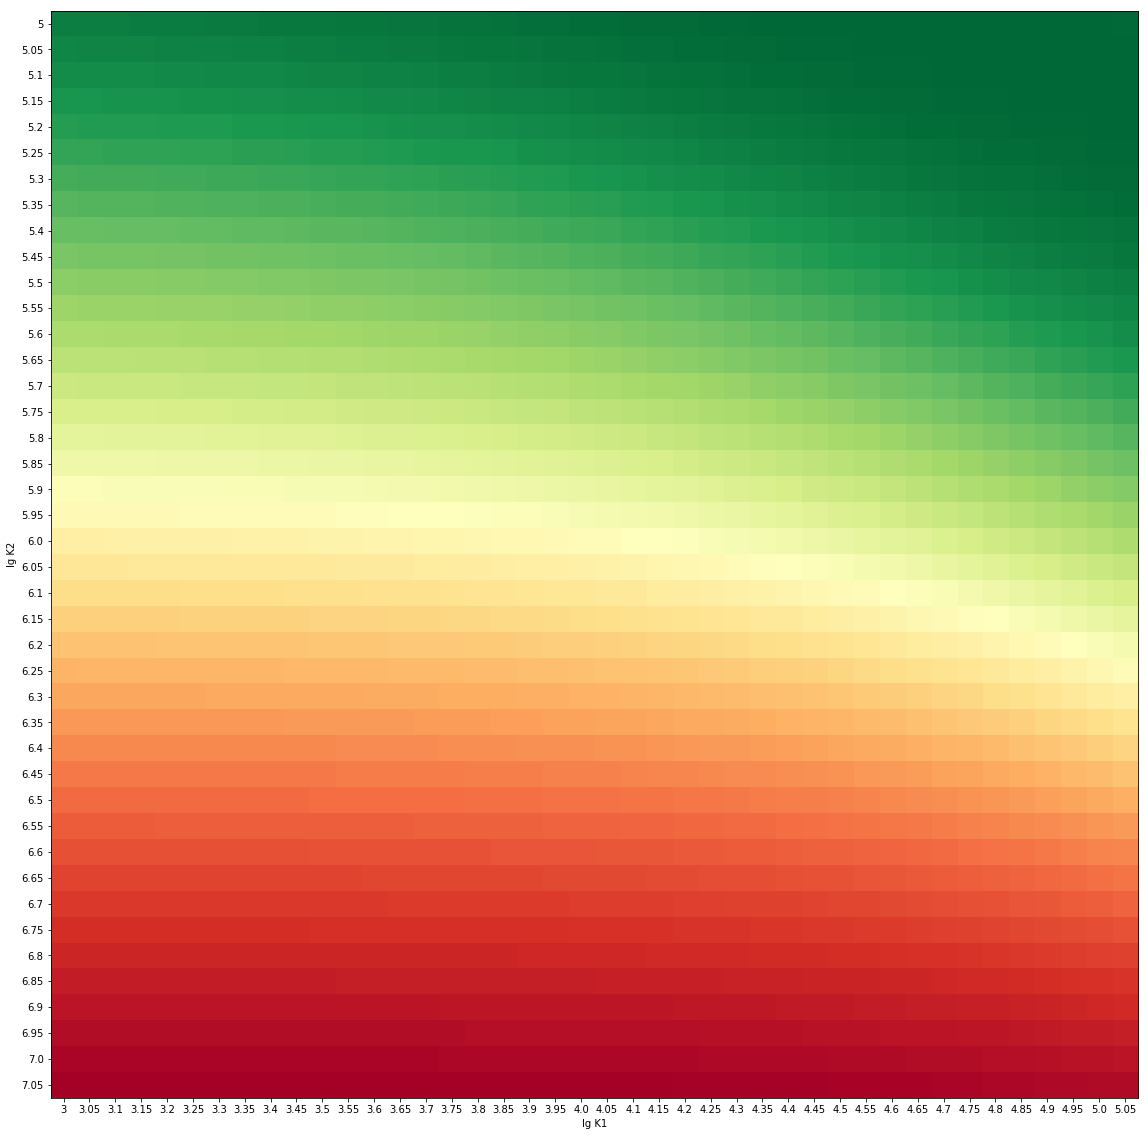

In [14]:
#comment this section for reducing the waiting time
s = risovalka(max_iter, eps, st_coeff_matrix, type_con, lg_k, con_matrix, ign_indices, ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                               _calor_setup_type_coeff, _calor_setup_type)
with pd.ExcelWriter('d:/KEVreplica/output/calorimetry/test_5.xlsx', mode = "w") as output:
    s.to_excel(output)

In [23]:
F_min, dH_res_out, disp = cl_enthalpies(ser_num, ser_counts, c_res_out, devs, volumes, heats, dH_ind, dH_par, dH_ind_wtf, 
                                                       _calor_setup_type_coeff, _calor_setup_type) 


eq con
[[1.00000000e-03 3.24423138e-17 2.10674427e-17 4.64902435e-17]
 [8.32410165e-04 6.56757936e-05 3.55011731e-05 6.52123843e-05]
 [7.07572295e-04 1.52611813e-04 7.01227552e-05 1.09491345e-04]
 [6.14926865e-04 2.56291907e-04 1.02343051e-04 1.38877480e-04]
 [5.44930007e-04 3.72177202e-04 1.31701430e-04 1.58373025e-04]
 [4.90669837e-04 4.96770022e-04 1.58286815e-04 1.71389457e-04]
 [4.47502395e-04 6.27609145e-04 1.82383114e-04 1.80106750e-04]
 [4.12345757e-04 7.62997617e-04 2.04307689e-04 1.85907214e-04]
 [3.83126958e-04 9.01755496e-04 2.24352808e-04 1.89681170e-04]
 [3.58419636e-04 1.04304638e-03 2.42770222e-04 1.92015908e-04]
 [3.37217511e-04 1.18626400e-03 2.59771480e-04 1.93308783e-04]
 [3.18793184e-04 1.33095903e-03 2.75533059e-04 1.93835242e-04]
 [3.02608865e-04 1.47679152e-03 2.90202292e-04 1.93790501e-04]
 [2.88258736e-04 1.62349937e-03 3.03902731e-04 1.93315679e-04]
 [2.75430877e-04 1.77087707e-03 3.16738634e-04 1.92514597e-04]
 [2.63881563e-04 1.91876100e-03 3.28798579e-04 